<a href="https://colab.research.google.com/github/KL193/DR_Research/blob/main/DR_Metadata_Synthesis_and_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio
!pip install pandas numpy matplotlib seaborn scikit-learn


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls "/content/drive/My Drive/DR_Project/dataset/messidor2"


messidor_data.csv  preprocess


In [5]:
import pandas as pd

path = '/content/drive/My Drive/DR_Project/dataset/messidor2/messidor_data.csv'
df = pd.read_csv(path)
df.head()


,id_code,diagnosis,adjudicated_dme,adjudicated_gradable
0,20051020_43808_0100_PP.png,0,0,1
1,20051020_43832_0100_PP.png,1,0,1
2,20051020_43882_0100_PP.png,1,0,1
3,20051020_43906_0100_PP.png,2,1,1
4,20051020_44261_0100_PP.png,0,0,1


In [6]:
import os

image_dir = '/content/drive/My Drive/DR_Project/dataset/messidor2/preprocess'
print("Total images:", len(os.listdir(image_dir)))
print("Example images:", os.listdir(image_dir)[:5])


Total images: 1744
Example images: ['20060411_61702_0200_PP.png', '20060411_61901_0200_PP.png', '20060411_62036_0200_PP.png', '20060411_62298_0200_PP.png', '20060412_52038_0200_PP.png']


In [7]:
import random

def generate_metadata(dr_grade):
    # Base ranges
    if dr_grade == 0:
        age = np.random.normal(45, 10)
        hba1c = np.random.normal(6.0, 0.5)
        duration = np.random.normal(3, 2)
        sbp = np.random.normal(120, 10)
    elif dr_grade == 1:
        age = np.random.normal(50, 10)
        hba1c = np.random.normal(7.0, 0.6)
        duration = np.random.normal(6, 3)
        sbp = np.random.normal(130, 12)
    elif dr_grade == 2:
        age = np.random.normal(55, 10)
        hba1c = np.random.normal(7.8, 0.7)
        duration = np.random.normal(10, 4)
        sbp = np.random.normal(140, 12)
    elif dr_grade == 3:
        age = np.random.normal(60, 8)
        hba1c = np.random.normal(8.6, 0.8)
        duration = np.random.normal(14, 5)
        sbp = np.random.normal(150, 15)
    else:
        age = np.random.normal(65, 8)
        hba1c = np.random.normal(9.4, 0.9)
        duration = np.random.normal(18, 5)
        sbp = np.random.normal(160, 15)

    return round(age,1), round(hba1c,1), round(duration,1), round(sbp,1)


metadata = df['diagnosis'].apply(lambda x: generate_metadata(x))
metadata_df = pd.DataFrame(metadata.tolist(), columns=['age','hba1c','duration','sbp'])
df = pd.concat([df, metadata_df], axis=1)
df.head()


,id_code,diagnosis,adjudicated_dme,adjudicated_gradable,age,hba1c,duration,sbp
0,20051020_43808_0100_PP.png,0,0,1,33.3,6.3,5.1,118.4
1,20051020_43832_0100_PP.png,1,0,1,37.0,6.9,1.1,154.7
2,20051020_43882_0100_PP.png,1,0,1,55.8,6.6,11.6,142.6
3,20051020_43906_0100_PP.png,2,1,1,51.0,7.6,8.2,169.6
4,20051020_44261_0100_PP.png,0,0,1,53.8,5.6,5.3,122.4


In [8]:
import os


os.makedirs('/content/drive/My Drive/DR_Project/data', exist_ok=True)

# Saving  the synthetic data csv
df.to_csv('/content/drive/My Drive/DR_Project/data/full_dataset_with_metadata.csv', index=False)



In [9]:

!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

!pip install -q efficientnet-pytorch==0.7.1


!pip install -q grad-cam


!pip install -q xgboost shap scikit-learn pandas numpy matplotlib seaborn torchsummary


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [10]:
# Basic setup
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50

from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import shap
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import joblib
from PIL import Image

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#Loading full dataset

csv_path = '/content/drive/My Drive/DR_Project/data/full_dataset_with_metadata.csv'
df = pd.read_csv(csv_path)

In [12]:
print("Columns:", df.columns.tolist())
print(df.head())

Columns: ['id_code', 'diagnosis', 'adjudicated_dme', 'adjudicated_gradable', 'age', 'hba1c', 'duration', 'sbp']
                      id_code  diagnosis  adjudicated_dme  \
0  20051020_43808_0100_PP.png          0                0   
1  20051020_43832_0100_PP.png          1                0   
2  20051020_43882_0100_PP.png          1                0   
3  20051020_43906_0100_PP.png          2                1   
4  20051020_44261_0100_PP.png          0                0   

   adjudicated_gradable   age  hba1c  duration    sbp  
0                     1  33.3    6.3       5.1  118.4  
1                     1  37.0    6.9       1.1  154.7  
2                     1  55.8    6.6      11.6  142.6  
3                     1  51.0    7.6       8.2  169.6  
4                     1  53.8    5.6       5.3  122.4  


Image 0: 20051020_43808_0100_PP.png → Exists? True


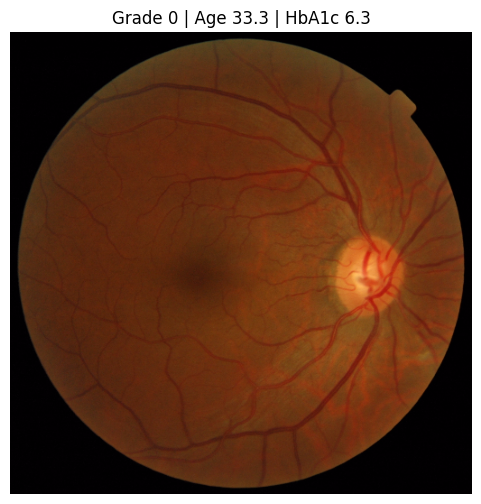

Image 1: 20051020_43832_0100_PP.png → Exists? True


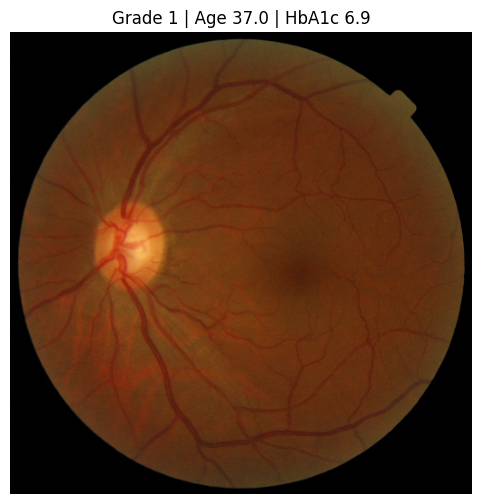

Image 2: 20051020_43882_0100_PP.png → Exists? True


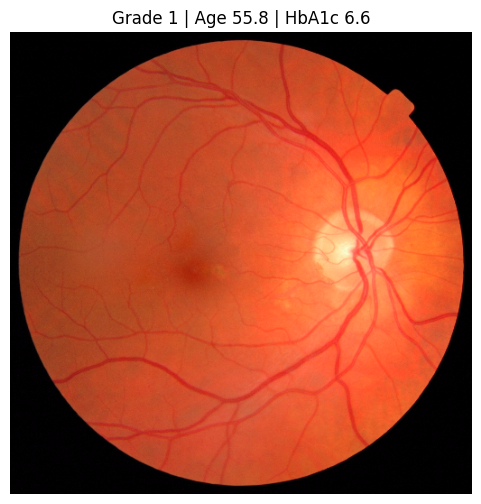

In [16]:

import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt


csv_path = '/content/drive/My Drive/DR_Project/data/full_dataset_with_metadata.csv'
df = pd.read_csv(csv_path)


df['filename'] = df['id_code']
image_dir = '/content/drive/My Drive/DR_Project/dataset/messidor2/preprocess'

# Test first 3 images
for i in range(3):
    path = os.path.join(image_dir, df.iloc[i]['filename'])
    print(f"Image {i}: {df.iloc[i]['filename']} → Exists? {os.path.exists(path)}")

    if os.path.exists(path):
        img = Image.open(path)
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.title(f"Grade {df.iloc[i]['diagnosis']} | Age {df.iloc[i]['age']} | HbA1c {df.iloc[i]['hba1c']}")
        plt.axis('off')
        plt.show()
    else:
        print("Still not found — check folder path!")